## Instalando biblioteca do Twitter

In [ ]:
!pip install tweepy

### Documentação da biblioteca Tweepy
https://docs.tweepy.org/en/latest/getting_started.html

In [ ]:
import tweepy as tw
import pandas as pd

## Chaves de acesso fornecidas pelo twitter
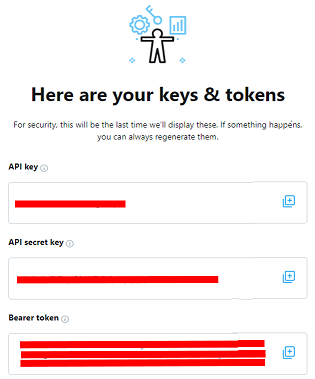

# Abrir documento que contém as informções de acesso

Vamos copiar as chaves de acesso fornecidas pelo twiter e salvar em um arquivo do tipo txt. 
Esse arquivo vamos salvar no diretório do projeto da coleta do Twitter. 

A ideia é ter as chaves salvas em um aquivo e depois criar um código em python para acessa-las lendo linha por linha e adicionando as variáveis para cada tipo de chave de acesso. Dessa forma, para cada linha do arquivo txt será a identificação de uma chave de acesso liberada pelo Twitter.

In [ ]:
with open ("twitter_token.txt", "r") as file:
    consumer_key = file.readline().strip('\n') # elimina o caracter \n que é uma quebra de linha
    consumer_secret = file.readline().strip('\n')
    token = file.readline().strip('\n')
    access_token = file.readline().strip('\n')
    access_token_secret = file.readline().strip('\n')

## Realizando autentificação na API do Twitter

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth) # Cria a conexão de acesso com o twitter

public_tweets = api.home_timeline() # Pega todos os primeiros twittes da timeline


## Visualizando os tweets  públicos da time line

In [ ]:
for tweet in public_tweets: # mostra os principais tweets da time line
    print(tweet.text)

##  Extraindo tweets baseado em tema

Para buscar os tweets vamos utilizar a função cursor da biblioteca tweepy.
Para saber como utilizar o cursor podemos abrir a documentação da biblioteca. https://docs.tweepy.org/en/v3.5.0/cursor_tutorial.html

In [ ]:
busca_palavras = "#vacina" #Cria uma variável que é atribuida as palavras que queremos extrair

In [ ]:
# busca todos os tweets relacionado a(s) palavra(s) procuradas
tweets = tw.Cursor(api.search, # metodo da API para busrcar tweets
            q=busca_palavras).items(50) # especifica o número de tweets retornados

### Verificando atributos disponibilização em um tweet

In [ ]:
for tweet in tweets:
    print(tweet.user.name, tweet.text) # traz o texto contidos nos tweets

## Verificando atributos chaves contidas dentro de um  tweet

In [ ]:
tweet._json

## Visualizando tweets coletados

Cada tweet possui uma série de atributos
Por exemplo:
    
    1.  created_at: Data da publicação
    2.  name: Contém o nome da pessoa 
    3.  description: Contém a descrição do usuário
    4.  location: Local onde foi postado o tweet
    5.  text - Texto que a pessoa postou
    

In [ ]:
# Para facilitar a visualização
vars(tweet).keys() #retornar todas as chaves dentro de tweets

In [ ]:
vars(tweet.user).keys() #retorna todas as chaves dentro do atributo user

In [ ]:
print(tweet.user.name,'-',tweet.user.location)

## Retirando tweets repetidos

Para retirar os tweets repetidos, vamos adicionar na string de busca o comando **"-filter:retweets"** para informar que não queremos informações de retweets

In [ ]:
busca_palavras = "#vacina" + "-filter:retweets" #Cria uma variável} que é atribuida as palavras que queremos extrair

In [ ]:
# busca todos os tweets relacionado a(s) palavra(s) procuradas
tweets = tw.Cursor(api.search, # metodo da API para busrcar tweets
            q=busca_palavras).items(50) # especifica o número de tweets retornados

In [ ]:
for tweet in tweets:
    print( tweet.created_at, '\n',  tweet.user.name, '\n', tweet.text, '\n') # traz o texto contidos nos tweets

### Observação Importante

O cursor é um método dinâmico. Dessa forma, todas as vezes que o método é executado novos resultados são retornados.
Isso acontece porque os tweets são postados a todo minuto. Ou seja, a busca é em tempo real. 

O proximo passo é criar uma estrututa de armazenamento para salvar os tweets que estamos coletando.


## Criando lista de armazenamento
Vamos criar uma lista vazia e adicionando os dados coletados de os tweets.

In [ ]:
busca_palavras = "#vacina" + "-filter:retweets" #Cria uma variável} que é atribuida as palavras que queremos extrair

# busca todos os tweets relacionado a(s) palavra(s) procuradas
tweets = tw.Cursor(api.search, # metodo da API para busrcar tweets
            q=busca_palavras).items(1500) # especifica o número de tweets retornados

In [ ]:
# Para cada tweet em tweets, vamos coletar as informações dos atributos que queremos armazenar.
lista_tweets = []
for tweet in tweets:
    dados_tweet = []
    dados_tweet.append(tweet.created_at) 
    dados_tweet.append(tweet.user.name) 
    dados_tweet.append(tweet.user.description) 
    dados_tweet.append(tweet.user.location)
    dados_tweet.append(tweet.text)
    
    lista_tweets.append(dados_tweet)

In [ ]:
lista_tweets[:5]

## Criando um dataframe para armzenamento da lista

Vamos criar um dataframe passando a lista dos tweets

In [ ]:
df_tweets= pd.DataFrame(lista_tweets, columns=['data', 'nome', 'descricao', 'localidade', 'post'])

In [ ]:
df_tweets

# Armazenando Tweets coletados no MongoDB

### instalando a biblioteca do Mongo para conexão com o banco de dados

In [ ]:
!pip install pymongo

### Importando o MongoClient para conexão e manipulação dos dados

In [ ]:
from pymongo import MongoClient

### Criando conexão com o banco de dados

In [ ]:
conn = MongoClient('localhost', 27017)
type(conn)

## Criando instância do MongoDB
### Vamos crirar implicitamente um banco de dados chamado tweetsdb

In [ ]:
db = conn.tweetsdb
type(db)

## Criando um coleção de documentos para ser armazenados no MongoDB

In [ ]:
collection = db.tweets_coletados
type(collection)

Para que a operação da criação do banco tweetsdb e da coleção coleta_tweet seja efetivada, precisamos inserir um documento na coleção.

# Transformando o dataframe em um dicionario
Os dados são armazenados no formato JSON no MongoDB. Deste modo, precisamos fazer o insert no banco através de uma estrutura de dados contendo chave e valor. Para isso vamos utilizar um dicionário.

In [ ]:
tweets_dict = df_tweets.to_dict('records')
tweets_dict[:3]

###  Quando um documento é inserido  é gerado uma chave especial chamada  "_id", 

Desta forma, ela é adiconada automaticamente se o documento não conter uma chave desse tipo '_id'

In [ ]:
# Inserindo os dados do tweet na coleção no banco MongoDB
for tweet in tweets_dict:
    post_id = collection.insert_one(tweet)
    post_id.inserted_id

# Operações de consulta do MongoDB pelo Python

## Verificando nome do banco criado

In [ ]:
db.name

## Verificando as coleções existentes

In [ ]:
db.list_collection_names()

## Buscando dados do banco

In [ ]:
import pprint # Biblioteca que facilita a visualização do tweets

In [ ]:
for tweet in db.tweets_coletados.find():
    print(tweet)

In [ ]:
for tweet in db.tweets_coletados.find():
    pprint.pprint(tweet)

## Realizando consulta no MongoDB utilizando o parâmentro de nome de usuário

Observação importante: A consulta abaixo realiza uma pesquisa de um usuário especifico que foi coletado na última extração dos tweets. Dessa forma, coletas futuras podem não conter tweets desse usuário em específico. Se isso acontecer, a consulta pode não trazer nenhum resultado. Para fins de testes, vocês podem alterar o nome do usuário a partir das suas coletas.

In [ ]:
for tweet in db.tweets_coletados.find({"nome": "GilbertoCostaOficial"}):
    pprint.pprint(tweet)


## Contanto um número de tweets dentro da coleção

In [ ]:
db.tweets_coletados.estimated_document_count()

In [ ]:
db.tweets_coletados.count_documents({})

## Importando dados de um aquivo Json

Vamos aprender a importar dados de um arquijo Json para dentro do MongoDB

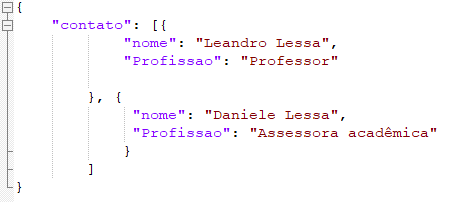

### Importando a biblioteca do JSON

In [ ]:
import json 

### Realizando leitura do arquivo

In [ ]:
with open('\\BASE_DESAFIO\\dados_contato.json', 'r') as file:
    arquivo = file.read()

In [ ]:
json_dados = json.loads(arquivo)

### Verificando estrutura de chaves do arquivo JSON

In [ ]:
json_dados.keys()

### Criando novo banco chamado pessoadb

In [ ]:
db = conn.pessoadb
type(db)

### Criando nova coleção chamada dados_pessoais

In [ ]:
collection = db.dados_pessoais

### Inserindo dados do arquivo JSON no banco MongoDB

In [ ]:
for dado in json_dados['contato']:
    dado_id = collection.insert_one(dado)
    dado_id.inserted_id

### Verificando quantidade de registros dentro da coleção

In [ ]:
db.dados_pessoais.estimated_document_count()

### Visualizando dados inseridos

In [ ]:
for dados in db.dados_pessoais.find():
    pprint.pprint(dados)